In [1]:
# Imports from the comp chem ecosystem
import nglview
import numpy as np
from openff.units import Quantity, unit
from openmm import unit as openmm_unit
# Imports from the toolkit
from openff.toolkit import ForceField, Molecule, Topology
from openmm.app import PDBFile, Modeller, ForceField as OpenMMForceField

from rdkit import Chem

%env OMP_NUM_THREADS=2

env: OMP_NUM_THREADS=2


In [3]:
!pwd

/home/xlian/OpenffAgent/notebooks


In [ ]:
import os
#os.chdir("/lus/flare/projects/FoundEpidem/xlian/OpenffAgent/notebooks")

FileNotFoundError: [Errno 2] No such file or directory: '/lus/flare/projects/FoundEpidem/xlian/OpenffAgent/notebooks'

In [4]:
ligand_path = "../tmp/ptm_lig/e4p_docked.sdf"

O=C[C@H](O)[C@H](O)COP(=O)([O-])[O-]


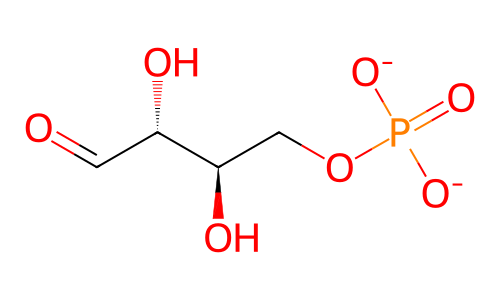

In [5]:
# Load a molecule from a SDF file
ligand = Molecule.from_file(ligand_path)

# Print out a SMILES code for the ligand
print(ligand.to_smiles(explicit_hydrogens=False))

# Visualize the molecule
ligand.visualize(show_all_hydrogens=False)

In [6]:
pdb_path = '../tmp/ptm_lig/pred.model_idx_0_fixed_chainA.pdb'
kpi_smiles_path = '../tmp/ptm_product.smiles'

# get smiles from txt
smiles = open(kpi_smiles_path, 'r').read()

print('number of atoms in smiles: ')
print(len(Chem.AddHs(Chem.MolFromSmiles(smiles)).GetAtoms()))

pdb = PDBFile(pdb_path)
num_atoms = sum(1 for _ in pdb.topology.atoms())
print("number of atoms in PDB:", num_atoms)

mol_withKPI_from_smiles = Molecule.from_pdb_and_smiles(pdb_path, smiles, allow_undefined_stereo=True)
print(f"✅ Loaded molecule with from_pdb_and_smiles()")

number of atoms in smiles: 
3032
number of atoms in PDB: 3032


/lus/eagle/projects/FoundEpidem/xlian/conda/envs/openff312/lib/python3.12/site-packages/openff/toolkit/utils/base_wrapper.py:67: MoleculeDeprecationWarning: `Molecule.from_pdb_and_smiles` is deprecated in favor of `Topology.from_pdb`, the recommended method for loading PDB files. This method will be removed in a future release of the OpenFF Toolkit.
  value = func(*args, **kwargs)
/lus/eagle/projects/FoundEpidem/xlian/conda/envs/openff312/lib/python3.12/site-packages/openff/toolkit/topology/molecule.py:4817: UserWarning: `RDKitToolkitWrapper.from_polymer_pdb` is deprecated in favor of `Topology.from_pdb`, the recommended method for loading PDB files. (Note the `unique_molecules` argument.) This method will be removed in a future release of the OpenFF Toolkit.
  return toolkit.from_pdb_and_smiles(file_path, smiles, allow_undefined_stereo, _cls=cls, name=name)


✅ Loaded molecule with from_pdb_and_smiles()


In [ ]:
topology = mol_withKPI_from_smiles.to_topology()
topology.n_molecules

1

In [7]:
import nglview
import numpy
import openmm
import openmm.app
import openmm.unit
from openff.toolkit import ForceField, Molecule, Topology
from openff.units import Quantity, unit
from openff.units.openmm import ensure_quantity
from openmm.app import Topology as OpenMMTopology

from openff.interchange import Interchange

OPENMM_IONS = {
    "Li+": "[#3+1]",
    "Na+": "[#11+1]",
    "K+": "[#19+1]",
    "Rb+": "[#37+1]",
    "Cs+": "[#55+1]",
    "F-": "[#9-1]",
    "Cl-": "[#17-1]",
    "Br-": "[#35-1]",
    "I-": "[#53-1]",
}


def visualize_all(interchange: Interchange) -> nglview.NGLWidget:
    view = interchange.visualize()
    view.clear_representations()
    view.add_representation("ball+stick", selection="all")
    return view


def solvate_topology(
    topology: Topology,
    method: str = "pdbfixer",
    box_vectors: Quantity | None = Quantity(5.0 * numpy.ones(3), unit.nanometer),
    **kwargs,
) -> Topology:
    if method in ["pdbfixer", "openmm"]:
        boxSize = openmm.unit.Quantity(openmm.Vec3(*box_vectors.m_as(unit.nanometer)), openmm.unit.nanometer)

        if method == "pdbfixer":
            openmm_topology, openmm_positions = _solvate_pdbfixer(
                topology.to_openmm(),
                topology.get_positions().to_openmm(),
                boxSize=boxSize,
                **kwargs,
            )
        else:
            openmm_topology, openmm_positions = _solvate_openmm(
                topology.to_openmm(),
                topology.get_positions().to_openmm(),
                box_vectors=boxSize,
                **kwargs,
            )

        unique_molecules: list[Molecule] = [*topology.unique_molecules]
        unique_molecules.append(Molecule.from_mapped_smiles("[H:2][O:1][H:3]"))

        if "positiveIon" in kwargs:
            unique_molecules.append(Molecule.from_smiles(OPENMM_IONS[kwargs["positiveIon"]]))

        if "negativeIon" in kwargs:
            unique_molecules.append(Molecule.from_smiles(OPENMM_IONS[kwargs["negativeIon"]]))

        new_topology = Topology.from_openmm(
            openmm_topology,
            unique_molecules=unique_molecules,
        )

        new_topology.set_positions(ensure_quantity(openmm_positions, "openff"))

        return new_topology


def _solvate_pdbfixer(
    topology: OpenMMTopology,
    positions: openmm.unit.Quantity,
    **kwargs,
) -> tuple[OpenMMTopology, openmm.unit.Quantity]:
    """
    Add solvent and ions using PDBFixer.

    https://htmlpreview.github.io/?https://github.com/openmm/pdbfixer/blob/master/Manual.html

    """
    import pdbfixer
    import os

    with open("_tmp.pdb", "w") as _file:
        openmm.app.PDBFile.writeFile(topology, positions, _file)

    pdb_object = pdbfixer.PDBFixer("_tmp.pdb")
    pdb_object.addSolvent(**kwargs)
    os.remove("_tmp.pdb")

    modeller = openmm.app.Modeller(pdb_object.topology, pdb_object.positions)

    # remove 3 CL-, gross!
    cl_residues = [r for r in modeller.topology.atoms() if r.name == 'Cl']
    modeller.delete(cl_residues[:3])

    return modeller.topology, modeller.positions


def _solvate_openmm(
    topology: OpenMMTopology,
    positions: openmm.unit.Quantity,
    box_vectors: openmm.unit.Quantity,
    forcefield: openmm.app.ForceField | None = None,
    **kwargs,
) -> tuple[OpenMMTopology, openmm.unit.Quantity]:
    if not forcefield:
        import pdbfixer

        forcefield = pdbfixer.PDBFixer._createForceField(topology)

    modeller = openmm.app.Modeller(topology, positions)
    modeller.addSolvent(
        forcefield,
        **kwargs,
    )

In [8]:
def insert_molecule_and_remove_clashes(
    topology: Topology,
    insert: Molecule,
    radius: Quantity = 1.5 * unit.angstrom,
    keep: list[Molecule] = [],
) -> Topology:
    """
    Add a molecule to a copy of the topology, removing any clashing molecules.

    The molecule will be added to the end of the topology. A new topology is
    returned; the input topology will not be altered. All molecules that
    clash will be removed, and each removed molecule will be printed to stdout.
    Users are responsible for ensuring that no important molecules have been
    removed; the clash radius may be modified accordingly.

    Parameters
    ==========
    top
        The topology to insert a molecule into
    insert
        The molecule to insert
    radius
        Any atom within this distance of any atom in the insert is considered
        clashing.
    keep
        Keep copies of these molecules, even if they're clashing
    """
    # We'll collect the molecules for the output topology into a list
    new_top_mols = []
    # A molecule's positions in a topology are stored as its zeroth conformer
    insert_coordinates = insert.conformers[0][:, None, :]
    for molecule in topology.molecules:
        if any(keep_mol.is_isomorphic_with(molecule) for keep_mol in keep):
            new_top_mols.append(molecule)
            continue
        molecule_coordinates = molecule.conformers[0][None, :, :]
        diff_matrix = molecule_coordinates - insert_coordinates

        # np.linalg.norm doesn't work on Pint quantities 😢
        working_unit = unit.nanometer
        distance_matrix = np.linalg.norm(diff_matrix.m_as(working_unit), axis=-1) * working_unit

        '''
        if distance_matrix.min() > radius:
            # This molecule is not clashing, so add it to the topology
            new_top_mols.append(molecule)
        else:
            print(f"Removed {molecule.to_smiles()} molecule")
        '''

        new_top_mols.append(molecule)

    # Insert the ligand at the end
    new_top_mols.append(ligand)

    # This pattern of assembling a topology from a list of molecules
    # ends up being much more efficient than adding each molecule
    # to a new topology one at a time
    new_top = Topology.from_molecules(new_top_mols)

    # Don't forget the box vectors!
    new_top.box_vectors = topology.box_vectors
    return new_top

In [9]:
top = insert_molecule_and_remove_clashes(topology, ligand)

# interchange_nw = sage_ff14sb.create_interchange(top)
# interchange_nw.to_inpcrd("nowater.inpcrd")
# interchange_nw.to_prmtop("nowater.prmtop")

top = solvate_topology(
    top,
    box_vectors=Quantity(7.0 * numpy.ones(3), unit.nanometer),
    positiveIon="Na+",
    negativeIon="Cl-",
    ionicStrength=0.15 * openmm.unit.molar,
)

In [10]:
n_na = sum(1 for atom in top.atoms if atom.symbol.upper() == "NA")
n_cl = sum(1 for atom in top.atoms if atom.symbol.upper() == "CL")

print("Na+", n_na)
print("Cl-", n_cl)

Na+ 32
Cl- 24


In [11]:
with open("../tmp/solvated_topology.json", "w") as f:
    print(top.to_json(), file=f)

In [12]:
sage_ff14sb = ForceField("openff-2.2.0.offxml", "ff14sb_off_impropers_0.0.4.offxml", "../output/KPI.offxml")
#interchange = sage_ff14sb.create_interchange(top)

In [7]:
with open("../tmp/solvated_topology.json", "r") as f:
    json_str = f.read()

top2load = Topology.from_json(json_str)

#top2load = Topology.from_json("solvated_topology.json")

In [8]:
sage_ff14sb = ForceField( "../output/KPI.offxml")
interchange = sage_ff14sb.create_interchange(top2load)

sh: /lus/eagle/projects/FoundEpidem/xlian/conda/envs/openff312/lib/libtinfo.so.6: no version information available (required by /lib64/libreadline.so.7)
/bin/bash: /lus/eagle/projects/FoundEpidem/xlian/conda/envs/openff312/lib/libtinfo.so.6: no version information available (required by /lib64/libreadline.so.7)
/usr/bin/lua5.3: /lus/eagle/projects/FoundEpidem/xlian/conda/envs/openff312/lib/libtinfo.so.6: no version information available (required by /lib64/libreadline.so.7)
sh: /lus/eagle/projects/FoundEpidem/xlian/conda/envs/openff312/lib/libtinfo.so.6: no version information available (required by /lib64/libreadline.so.7)
/bin/bash: /lus/eagle/projects/FoundEpidem/xlian/conda/envs/openff312/lib/libtinfo.so.6: no version information available (required by /lib64/libreadline.so.7)
/usr/bin/lua5.3: /lus/eagle/projects/FoundEpidem/xlian/conda/envs/openff312/lib/libtinfo.so.6: no version information available (required by /lib64/libreadline.so.7)
sh: /lus/eagle/projects/FoundEpidem/xlian/

In [9]:
interchange.visualize()

NGLWidget()

In [ ]:
# system_intrcg = Interchange.from_smirnoff(
#     force_field=sage_ff14sb,
#     topology=top,
# )

In [ ]:
openmm_system = interchange.to_openmm()
openmm_topology = interchange.to_openmm_topology()
openmm_positions = interchange.positions.to_openmm()

In [ ]:
import time
import openmm

# https://docs.openforcefield.org/en/latest/examples/openforcefield/openff-interchange/openmm/openmm.html
# Length of the simulation.
num_steps = 10_000_000  # number of integration steps to run

# Logging options.
trj_freq = 100_000  # number of steps per written trajectory frame
data_freq = 100_000  # number of steps per written simulation statistics

# Integration options
time_step = 1 * openmm.unit.femtoseconds  # simulation timestep
temperature = 300 * openmm.unit.kelvin  # simulation temperature
friction = 1 / openmm.unit.picosecond  # friction constant

integrator = openmm.LangevinMiddleIntegrator(temperature, friction, time_step)
simulation = interchange.to_openmm_simulation(integrator=integrator)

In [7]:
#simulation.context.setPositions(openmm_positions)
simulation.context.setVelocitiesToTemperature(temperature)

# Filenames
dcd_file = "traj.dcd"
log_file = "traj.log"

# Add reporters
simulation.reporters.extend([
    # ⚠️ enforcePeriodicBox=True is CRITICAL for wrapping protein into the box
    openmm.app.DCDReporter(
        dcd_file,
        trj_freq,
        enforcePeriodicBox=True
    ),

    # Simulation log output (StateDataReporter)
    openmm.app.StateDataReporter(
        log_file,
        data_freq,
        step=True,
        potentialEnergy=True,
        kineticEnergy=True,
        totalEnergy=True,
        temperature=True,
        volume=True,
        density=True,
        progress=True,
        remainingTime=True,
        speed=True,
        totalSteps=num_steps,
        separator=','
    )
])


In [8]:
simulation.minimizeEnergy()

In [11]:
state = simulation.context.getState(getPositions=True)
min_positions = state.getPositions()

# Write PDB
with open("../tmp/minimized.pdb", "w") as f:
    PDBFile.writeFile(openmm_topology, min_positions, f)

In [ ]:
print("Starting simulation")
start = time.process_time()

# Run the simulation
simulation.step(num_steps)

end = time.process_time()
print(f"Elapsed time {end - start} seconds")
print("Done!")

Starting simulation


In [ ]:
state = simulation.context.getState(getEnergy=True)
print("energy:", state.getPotentialEnergy())

Initial energy: -428199.34801221266 kJ/mol


In [ ]:
system = simulation.system
for i, f in enumerate(system.getForces()):
    print(i, type(f))

0 <class 'openmm.openmm.NonbondedForce'>
1 <class 'openmm.openmm.PeriodicTorsionForce'>
2 <class 'openmm.openmm.HarmonicAngleForce'>
3 <class 'openmm.openmm.HarmonicBondForce'>
4 <class 'openmm.openmm.CMMotionRemover'>


In [ ]:
import mdtraj as md
import nglview
nglview.show_mdtraj(md.load("trajectory.pdb"))

OSError: No such file: trajectory.pdb

In [ ]:
from openff.interchange.drivers import get_openmm_energies
get_openmm_energies(interchange)

EnergyReport(energies={'Bond': <Quantity(581.736035, 'kilojoule / mole')>, 'Angle': <Quantity(18298.4107, 'kilojoule / mole')>, 'Torsion': <Quantity(16760.7978, 'kilojoule / mole')>, 'Nonbonded': <Quantity(-226171.343, 'kilojoule / mole')>})

In [ ]:
from openff.interchange.drivers.all import get_summary_data

summary = get_summary_data(interchange, _engines=["OpenMM", "GROMACS", "Amber"])
summary

/home/xlian/.conda/envs/agent/lib/python3.13/site-packages/openff/interchange/components/mdconfig.py:503: UserWarning: Ambiguous failure while processing constraints. Constraining h-bonds as a stopgap.
  warnings.warn(
/home/xlian/.conda/envs/agent/lib/python3.13/site-packages/openff/interchange/components/mdconfig.py:431: SwitchingFunctionNotImplementedWarning: A switching distance 8.0 angstrom was specified by the force field, but Amber does not implement a switching function. Using a hard cut-off instead. Non-bonded interactions will be affected.
  warnings.warn(
/home/xlian/.conda/envs/agent/lib/python3.13/site-packages/openff/interchange/components/mdconfig.py:503: UserWarning: Ambiguous failure while processing constraints. Constraining h-bonds as a stopgap.
  warnings.warn(


,Bond,Angle,Torsion,vdW,Electrostatics
OpenMM,581.736035,18298.410674,16760.797848,209336.871761,-435508.214128


In [ ]:
import openmm

nbforce = openmm_system.getForces()[0]
charge = 0 * openmm.unit.elementary_charge
for i in range(nbforce.getNumParticles()):
    charge += nbforce.getParticleParameters(i)[0]
charge

-1.278653556369136e-07 e